# 24-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers


## Step1. 데이터 준비

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


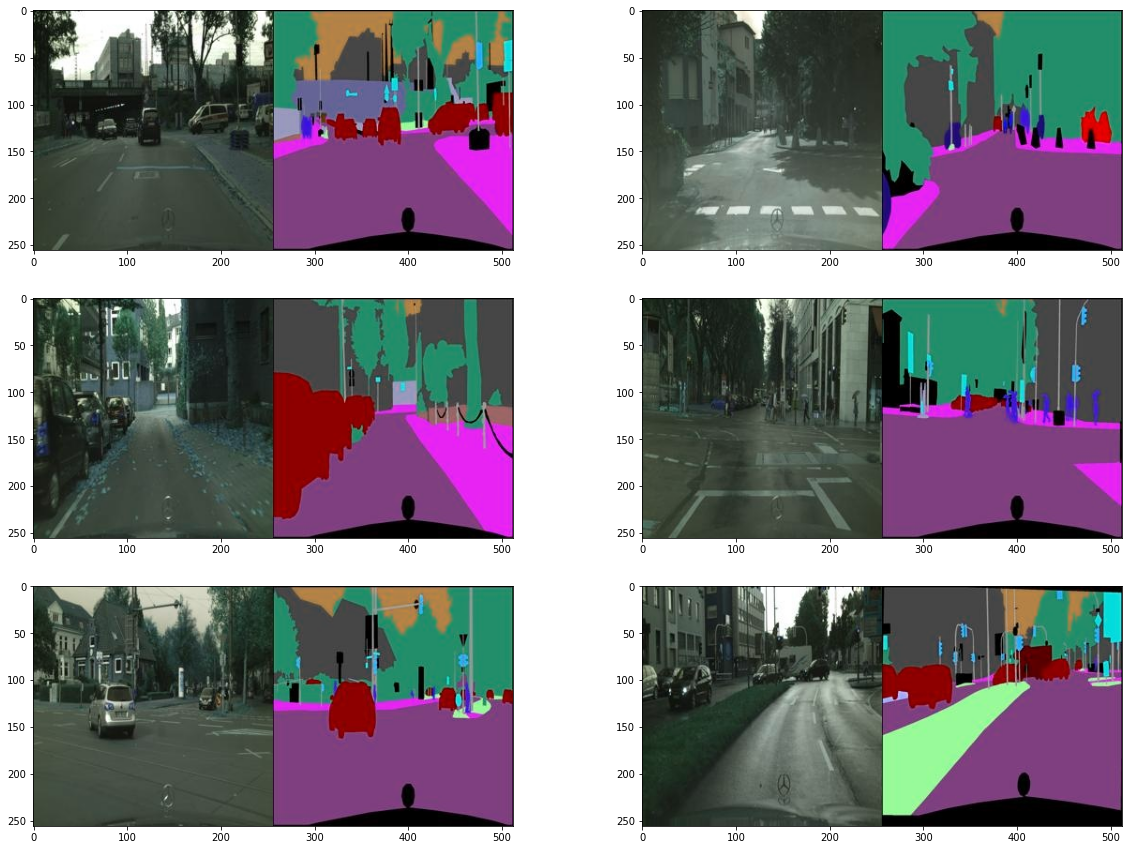

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

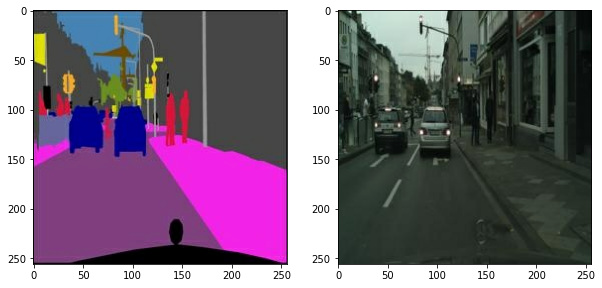

In [6]:
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [7]:
print(denormalize(sketch).shape)

(256, 256, 3)


In [8]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("적용된 augmentation : reflect, crop, rotation")

적용된 augmentation : reflect, crop, rotation


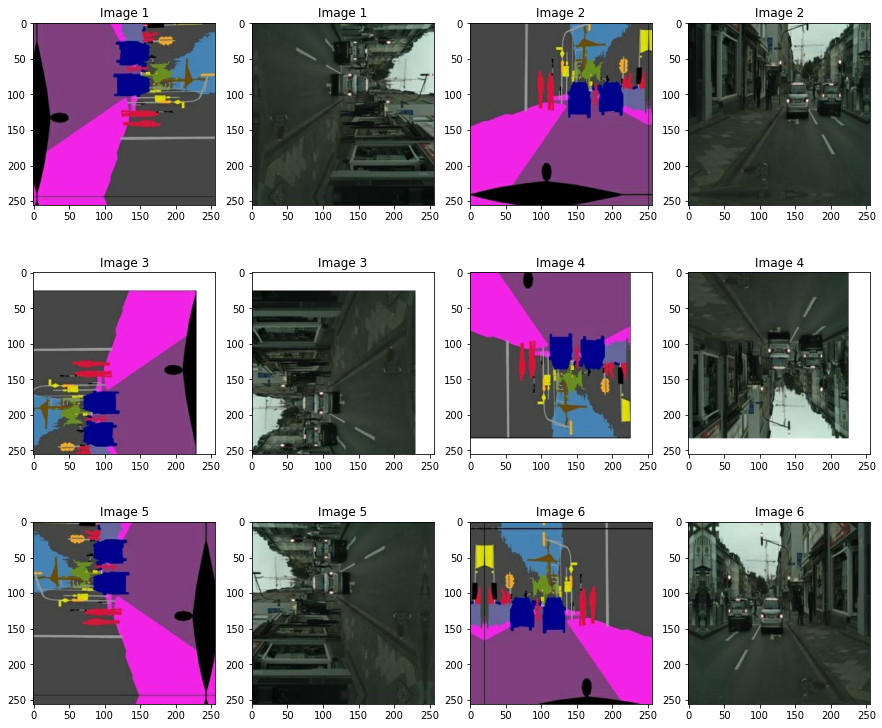

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

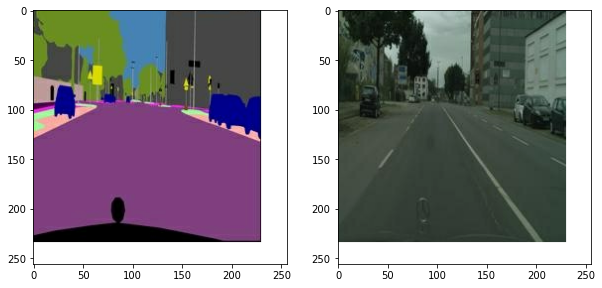

In [10]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Step2. 모델 설계하기

### Generator 생성하기

In [11]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [12]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [13]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### Discriminator 생성하기

In [14]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [15]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [17]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## Step3. 학습하기

### 손실함수 및 옵티마이저 구현

In [18]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [19]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [20]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


학습

In [21]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()
Generator_loss_log = []
L1_loss_log = []
Discriminator_loss_log = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            Generator_loss_log.append(g_loss)
            L1_loss_log.append(l1_loss)
            Discriminator_loss_log.append(d_loss)
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9587                     
L1_loss:0.3660                     
Discriminator_loss:1.1975

EPOCH[1] - STEP[20]                     
Generator_loss:1.0845                     
L1_loss:0.2935                     
Discriminator_loss:1.2633

EPOCH[1] - STEP[30]                     
Generator_loss:1.1725                     
L1_loss:0.2358                     
Discriminator_loss:1.3206

EPOCH[1] - STEP[40]                     
Generator_loss:1.0144                     
L1_loss:0.1898                     
Discriminator_loss:1.3319

EPOCH[1] - STEP[50]                     
Generator_loss:0.8284                     
L1_loss:0.2116                     
Discriminator_loss:1.2878

EPOCH[1] - STEP[60]                     
Generator_loss:0.8367                     
L1_loss:0.2046                     
Discriminator_loss:1.0901

EPOCH[1] - STEP[70]                     
Generator_loss:0.9239                     
L1_loss:0.1829                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.7183                     
L1_loss:0.1566                     
Discriminator_loss:1.2923

EPOCH[3] - STEP[80]                     
Generator_loss:1.8965                     
L1_loss:0.1645                     
Discriminator_loss:0.9809

EPOCH[3] - STEP[90]                     
Generator_loss:0.3218                     
L1_loss:0.1551                     
Discriminator_loss:1.6218

EPOCH[3] - STEP[100]                     
Generator_loss:1.7250                     
L1_loss:0.1808                     
Discriminator_loss:0.5177

EPOCH[3] - STEP[110]                     
Generator_loss:1.9818                     
L1_loss:0.1903                     
Discriminator_loss:0.3925

EPOCH[3] - STEP[120]                     
Generator_loss:1.5102                     
L1_loss:0.1705                     
Discriminator_loss:1.5969

EPOCH[3] - STEP[130]                     
Generator_loss:2.4633                     
L1_loss:0.1737                

EPOCH[5] - STEP[130]                     
Generator_loss:1.3711                     
L1_loss:0.1891                     
Discriminator_loss:0.6656

EPOCH[5] - STEP[140]                     
Generator_loss:1.5673                     
L1_loss:0.1631                     
Discriminator_loss:1.2514

EPOCH[5] - STEP[150]                     
Generator_loss:1.6514                     
L1_loss:0.2264                     
Discriminator_loss:0.3078

EPOCH[5] - STEP[160]                     
Generator_loss:1.9332                     
L1_loss:0.1713                     
Discriminator_loss:0.7866

EPOCH[5] - STEP[170]                     
Generator_loss:1.1147                     
L1_loss:0.1942                     
Discriminator_loss:0.5122

EPOCH[5] - STEP[180]                     
Generator_loss:2.1571                     
L1_loss:0.1725                     
Discriminator_loss:1.2017

EPOCH[5] - STEP[190]                     
Generator_loss:0.8150                     
L1_loss:0.1889             

EPOCH[7] - STEP[190]                     
Generator_loss:0.9626                     
L1_loss:0.1827                     
Discriminator_loss:1.1357

EPOCH[7] - STEP[200]                     
Generator_loss:1.5543                     
L1_loss:0.1554                     
Discriminator_loss:0.8037

EPOCH[7] - STEP[210]                     
Generator_loss:1.4568                     
L1_loss:0.1780                     
Discriminator_loss:2.6603

EPOCH[7] - STEP[220]                     
Generator_loss:0.5865                     
L1_loss:0.1794                     
Discriminator_loss:1.0408

EPOCH[7] - STEP[230]                     
Generator_loss:1.7248                     
L1_loss:0.1761                     
Discriminator_loss:1.4959

EPOCH[7] - STEP[240]                     
Generator_loss:1.1153                     
L1_loss:0.1811                     
Discriminator_loss:0.5716

EPOCH[7] - STEP[250]                     
Generator_loss:1.1739                     
L1_loss:0.2034             

EPOCH[9] - STEP[250]                     
Generator_loss:2.2548                     
L1_loss:0.1666                     
Discriminator_loss:0.7777

EPOCH[10] - STEP[10]                     
Generator_loss:0.4263                     
L1_loss:0.1952                     
Discriminator_loss:1.7067

EPOCH[10] - STEP[20]                     
Generator_loss:2.0429                     
L1_loss:0.1613                     
Discriminator_loss:1.8917

EPOCH[10] - STEP[30]                     
Generator_loss:1.0510                     
L1_loss:0.2047                     
Discriminator_loss:0.7752

EPOCH[10] - STEP[40]                     
Generator_loss:0.7456                     
L1_loss:0.2037                     
Discriminator_loss:0.7638

EPOCH[10] - STEP[50]                     
Generator_loss:1.2873                     
L1_loss:0.1734                     
Discriminator_loss:0.5178

EPOCH[10] - STEP[60]                     
Generator_loss:0.7496                     
L1_loss:0.1824             

EPOCH[12] - STEP[60]                     
Generator_loss:0.7507                     
L1_loss:0.1836                     
Discriminator_loss:0.8499

EPOCH[12] - STEP[70]                     
Generator_loss:0.9801                     
L1_loss:0.2179                     
Discriminator_loss:0.5677

EPOCH[12] - STEP[80]                     
Generator_loss:1.3129                     
L1_loss:0.1606                     
Discriminator_loss:1.3654

EPOCH[12] - STEP[90]                     
Generator_loss:2.2692                     
L1_loss:0.1907                     
Discriminator_loss:1.3404

EPOCH[12] - STEP[100]                     
Generator_loss:2.3237                     
L1_loss:0.1675                     
Discriminator_loss:0.2836

EPOCH[12] - STEP[110]                     
Generator_loss:1.0568                     
L1_loss:0.1770                     
Discriminator_loss:0.5789

EPOCH[12] - STEP[120]                     
Generator_loss:1.5888                     
L1_loss:0.1978          

EPOCH[14] - STEP[120]                     
Generator_loss:0.4209                     
L1_loss:0.1783                     
Discriminator_loss:1.5491

EPOCH[14] - STEP[130]                     
Generator_loss:0.8753                     
L1_loss:0.1958                     
Discriminator_loss:0.7086

EPOCH[14] - STEP[140]                     
Generator_loss:1.5900                     
L1_loss:0.2055                     
Discriminator_loss:0.5554

EPOCH[14] - STEP[150]                     
Generator_loss:0.4704                     
L1_loss:0.1429                     
Discriminator_loss:1.2507

EPOCH[14] - STEP[160]                     
Generator_loss:0.5640                     
L1_loss:0.1533                     
Discriminator_loss:1.5974

EPOCH[14] - STEP[170]                     
Generator_loss:1.4131                     
L1_loss:0.1507                     
Discriminator_loss:1.1420

EPOCH[14] - STEP[180]                     
Generator_loss:1.3893                     
L1_loss:0.1565      

EPOCH[16] - STEP[180]                     
Generator_loss:1.7017                     
L1_loss:0.1763                     
Discriminator_loss:0.6872

EPOCH[16] - STEP[190]                     
Generator_loss:2.2806                     
L1_loss:0.1875                     
Discriminator_loss:0.5484

EPOCH[16] - STEP[200]                     
Generator_loss:1.1535                     
L1_loss:0.1848                     
Discriminator_loss:1.2782

EPOCH[16] - STEP[210]                     
Generator_loss:1.0690                     
L1_loss:0.1384                     
Discriminator_loss:1.2052

EPOCH[16] - STEP[220]                     
Generator_loss:1.4242                     
L1_loss:0.1638                     
Discriminator_loss:1.2960

EPOCH[16] - STEP[230]                     
Generator_loss:0.7080                     
L1_loss:0.2080                     
Discriminator_loss:1.0084

EPOCH[16] - STEP[240]                     
Generator_loss:1.7320                     
L1_loss:0.1732      

EPOCH[18] - STEP[240]                     
Generator_loss:0.8486                     
L1_loss:0.1548                     
Discriminator_loss:1.4571

EPOCH[18] - STEP[250]                     
Generator_loss:2.5169                     
L1_loss:0.2096                     
Discriminator_loss:0.1521

EPOCH[19] - STEP[10]                     
Generator_loss:1.1369                     
L1_loss:0.1943                     
Discriminator_loss:0.4799

EPOCH[19] - STEP[20]                     
Generator_loss:0.9933                     
L1_loss:0.1817                     
Discriminator_loss:0.9212

EPOCH[19] - STEP[30]                     
Generator_loss:1.1894                     
L1_loss:0.1932                     
Discriminator_loss:0.4325

EPOCH[19] - STEP[40]                     
Generator_loss:1.5356                     
L1_loss:0.1891                     
Discriminator_loss:0.4317

EPOCH[19] - STEP[50]                     
Generator_loss:2.1415                     
L1_loss:0.2118           

EPOCH[21] - STEP[50]                     
Generator_loss:1.5942                     
L1_loss:0.1541                     
Discriminator_loss:1.0643

EPOCH[21] - STEP[60]                     
Generator_loss:0.8107                     
L1_loss:0.1784                     
Discriminator_loss:0.7792

EPOCH[21] - STEP[70]                     
Generator_loss:0.7883                     
L1_loss:0.1768                     
Discriminator_loss:0.9027

EPOCH[21] - STEP[80]                     
Generator_loss:0.6793                     
L1_loss:0.1868                     
Discriminator_loss:0.8298

EPOCH[21] - STEP[90]                     
Generator_loss:1.5015                     
L1_loss:0.1590                     
Discriminator_loss:1.1313

EPOCH[21] - STEP[100]                     
Generator_loss:1.4873                     
L1_loss:0.1714                     
Discriminator_loss:0.6704

EPOCH[21] - STEP[110]                     
Generator_loss:1.1679                     
L1_loss:0.1839           

EPOCH[23] - STEP[110]                     
Generator_loss:1.9005                     
L1_loss:0.2115                     
Discriminator_loss:0.2979

EPOCH[23] - STEP[120]                     
Generator_loss:1.2493                     
L1_loss:0.1671                     
Discriminator_loss:1.3707

EPOCH[23] - STEP[130]                     
Generator_loss:0.9871                     
L1_loss:0.1808                     
Discriminator_loss:0.5599

EPOCH[23] - STEP[140]                     
Generator_loss:1.2915                     
L1_loss:0.1716                     
Discriminator_loss:1.8638

EPOCH[23] - STEP[150]                     
Generator_loss:0.9639                     
L1_loss:0.1312                     
Discriminator_loss:1.5777

EPOCH[23] - STEP[160]                     
Generator_loss:1.6026                     
L1_loss:0.1462                     
Discriminator_loss:0.9622

EPOCH[23] - STEP[170]                     
Generator_loss:1.5488                     
L1_loss:0.1906      

EPOCH[25] - STEP[170]                     
Generator_loss:1.9204                     
L1_loss:0.1813                     
Discriminator_loss:1.6180

EPOCH[25] - STEP[180]                     
Generator_loss:0.8562                     
L1_loss:0.1942                     
Discriminator_loss:0.8241

EPOCH[25] - STEP[190]                     
Generator_loss:0.9039                     
L1_loss:0.1705                     
Discriminator_loss:0.7568

EPOCH[25] - STEP[200]                     
Generator_loss:1.2828                     
L1_loss:0.1700                     
Discriminator_loss:0.8729

EPOCH[25] - STEP[210]                     
Generator_loss:1.7515                     
L1_loss:0.1501                     
Discriminator_loss:1.2727

EPOCH[25] - STEP[220]                     
Generator_loss:1.7527                     
L1_loss:0.1793                     
Discriminator_loss:0.3792

EPOCH[25] - STEP[230]                     
Generator_loss:1.5860                     
L1_loss:0.1574      

EPOCH[27] - STEP[230]                     
Generator_loss:1.7846                     
L1_loss:0.1689                     
Discriminator_loss:0.6776

EPOCH[27] - STEP[240]                     
Generator_loss:1.1025                     
L1_loss:0.1982                     
Discriminator_loss:0.5704

EPOCH[27] - STEP[250]                     
Generator_loss:0.5163                     
L1_loss:0.2026                     
Discriminator_loss:1.0144

EPOCH[28] - STEP[10]                     
Generator_loss:1.1558                     
L1_loss:0.1669                     
Discriminator_loss:0.6951

EPOCH[28] - STEP[20]                     
Generator_loss:1.8586                     
L1_loss:0.1998                     
Discriminator_loss:0.4807

EPOCH[28] - STEP[30]                     
Generator_loss:1.8014                     
L1_loss:0.1843                     
Discriminator_loss:0.8813

EPOCH[28] - STEP[40]                     
Generator_loss:1.3725                     
L1_loss:0.1977          

EPOCH[30] - STEP[40]                     
Generator_loss:2.2439                     
L1_loss:0.1644                     
Discriminator_loss:1.4074

EPOCH[30] - STEP[50]                     
Generator_loss:2.1545                     
L1_loss:0.1562                     
Discriminator_loss:0.6900

EPOCH[30] - STEP[60]                     
Generator_loss:0.9658                     
L1_loss:0.1528                     
Discriminator_loss:1.7321

EPOCH[30] - STEP[70]                     
Generator_loss:0.5989                     
L1_loss:0.1328                     
Discriminator_loss:1.1611

EPOCH[30] - STEP[80]                     
Generator_loss:0.8635                     
L1_loss:0.1861                     
Discriminator_loss:0.7461

EPOCH[30] - STEP[90]                     
Generator_loss:1.9779                     
L1_loss:0.1866                     
Discriminator_loss:1.3616

EPOCH[30] - STEP[100]                     
Generator_loss:1.1327                     
L1_loss:0.1738            

EPOCH[32] - STEP[100]                     
Generator_loss:0.6579                     
L1_loss:0.1860                     
Discriminator_loss:1.6555

EPOCH[32] - STEP[110]                     
Generator_loss:1.3333                     
L1_loss:0.1737                     
Discriminator_loss:1.0549

EPOCH[32] - STEP[120]                     
Generator_loss:1.1979                     
L1_loss:0.1970                     
Discriminator_loss:0.6841

EPOCH[32] - STEP[130]                     
Generator_loss:1.6955                     
L1_loss:0.2096                     
Discriminator_loss:0.3343

EPOCH[32] - STEP[140]                     
Generator_loss:1.0813                     
L1_loss:0.1469                     
Discriminator_loss:1.1990

EPOCH[32] - STEP[150]                     
Generator_loss:2.1392                     
L1_loss:0.1554                     
Discriminator_loss:2.6768

EPOCH[32] - STEP[160]                     
Generator_loss:2.4237                     
L1_loss:0.1614      

EPOCH[34] - STEP[160]                     
Generator_loss:1.2068                     
L1_loss:0.1813                     
Discriminator_loss:1.7115

EPOCH[34] - STEP[170]                     
Generator_loss:1.0720                     
L1_loss:0.1754                     
Discriminator_loss:0.6200

EPOCH[34] - STEP[180]                     
Generator_loss:1.7016                     
L1_loss:0.1608                     
Discriminator_loss:2.4292

EPOCH[34] - STEP[190]                     
Generator_loss:1.5707                     
L1_loss:0.1904                     
Discriminator_loss:0.4172

EPOCH[34] - STEP[200]                     
Generator_loss:1.0793                     
L1_loss:0.2274                     
Discriminator_loss:0.4911

EPOCH[34] - STEP[210]                     
Generator_loss:2.6219                     
L1_loss:0.1756                     
Discriminator_loss:0.6661

EPOCH[34] - STEP[220]                     
Generator_loss:2.1008                     
L1_loss:0.1626      

EPOCH[36] - STEP[220]                     
Generator_loss:0.7642                     
L1_loss:0.1571                     
Discriminator_loss:0.9934

EPOCH[36] - STEP[230]                     
Generator_loss:2.3158                     
L1_loss:0.1689                     
Discriminator_loss:2.4564

EPOCH[36] - STEP[240]                     
Generator_loss:1.7176                     
L1_loss:0.1597                     
Discriminator_loss:0.4925

EPOCH[36] - STEP[250]                     
Generator_loss:1.9155                     
L1_loss:0.1814                     
Discriminator_loss:0.8972

EPOCH[37] - STEP[10]                     
Generator_loss:1.0459                     
L1_loss:0.1649                     
Discriminator_loss:0.6200

EPOCH[37] - STEP[20]                     
Generator_loss:0.1788                     
L1_loss:0.1904                     
Discriminator_loss:2.7877

EPOCH[37] - STEP[30]                     
Generator_loss:2.2797                     
L1_loss:0.1657         

EPOCH[39] - STEP[30]                     
Generator_loss:2.5750                     
L1_loss:0.1776                     
Discriminator_loss:2.5207

EPOCH[39] - STEP[40]                     
Generator_loss:2.3221                     
L1_loss:0.1549                     
Discriminator_loss:1.2176

EPOCH[39] - STEP[50]                     
Generator_loss:2.6841                     
L1_loss:0.1627                     
Discriminator_loss:2.3696

EPOCH[39] - STEP[60]                     
Generator_loss:1.8929                     
L1_loss:0.1497                     
Discriminator_loss:0.9475

EPOCH[39] - STEP[70]                     
Generator_loss:1.2119                     
L1_loss:0.1801                     
Discriminator_loss:0.8271

EPOCH[39] - STEP[80]                     
Generator_loss:0.8951                     
L1_loss:0.1710                     
Discriminator_loss:0.7503

EPOCH[39] - STEP[90]                     
Generator_loss:0.1011                     
L1_loss:0.1771             

EPOCH[41] - STEP[90]                     
Generator_loss:2.0541                     
L1_loss:0.1657                     
Discriminator_loss:1.7025

EPOCH[41] - STEP[100]                     
Generator_loss:0.7468                     
L1_loss:0.1678                     
Discriminator_loss:0.8007

EPOCH[41] - STEP[110]                     
Generator_loss:0.7775                     
L1_loss:0.1822                     
Discriminator_loss:0.9325

EPOCH[41] - STEP[120]                     
Generator_loss:1.6453                     
L1_loss:0.1755                     
Discriminator_loss:0.4279

EPOCH[41] - STEP[130]                     
Generator_loss:1.1038                     
L1_loss:0.1776                     
Discriminator_loss:1.1845

EPOCH[41] - STEP[140]                     
Generator_loss:3.1313                     
L1_loss:0.1779                     
Discriminator_loss:0.5066

EPOCH[41] - STEP[150]                     
Generator_loss:2.2031                     
L1_loss:0.1690       

EPOCH[43] - STEP[150]                     
Generator_loss:1.8436                     
L1_loss:0.1686                     
Discriminator_loss:0.4713

EPOCH[43] - STEP[160]                     
Generator_loss:1.4722                     
L1_loss:0.1639                     
Discriminator_loss:0.9355

EPOCH[43] - STEP[170]                     
Generator_loss:1.3215                     
L1_loss:0.1857                     
Discriminator_loss:0.4695

EPOCH[43] - STEP[180]                     
Generator_loss:3.0768                     
L1_loss:0.1399                     
Discriminator_loss:1.8734

EPOCH[43] - STEP[190]                     
Generator_loss:1.5431                     
L1_loss:0.2027                     
Discriminator_loss:0.2894

EPOCH[43] - STEP[200]                     
Generator_loss:1.2913                     
L1_loss:0.1641                     
Discriminator_loss:1.4826

EPOCH[43] - STEP[210]                     
Generator_loss:1.5864                     
L1_loss:0.1537      

EPOCH[45] - STEP[210]                     
Generator_loss:1.0563                     
L1_loss:0.1877                     
Discriminator_loss:0.5485

EPOCH[45] - STEP[220]                     
Generator_loss:1.4325                     
L1_loss:0.1650                     
Discriminator_loss:0.5829

EPOCH[45] - STEP[230]                     
Generator_loss:1.8842                     
L1_loss:0.1643                     
Discriminator_loss:0.6165

EPOCH[45] - STEP[240]                     
Generator_loss:1.7069                     
L1_loss:0.2013                     
Discriminator_loss:0.2545

EPOCH[45] - STEP[250]                     
Generator_loss:1.5439                     
L1_loss:0.1780                     
Discriminator_loss:0.4112

EPOCH[46] - STEP[10]                     
Generator_loss:1.8563                     
L1_loss:0.1687                     
Discriminator_loss:0.6099

EPOCH[46] - STEP[20]                     
Generator_loss:0.9462                     
L1_loss:0.1574        

EPOCH[48] - STEP[20]                     
Generator_loss:2.1475                     
L1_loss:0.1612                     
Discriminator_loss:1.3901

EPOCH[48] - STEP[30]                     
Generator_loss:1.7409                     
L1_loss:0.1673                     
Discriminator_loss:1.1606

EPOCH[48] - STEP[40]                     
Generator_loss:1.3307                     
L1_loss:0.1729                     
Discriminator_loss:1.0698

EPOCH[48] - STEP[50]                     
Generator_loss:1.1970                     
L1_loss:0.1603                     
Discriminator_loss:1.0115

EPOCH[48] - STEP[60]                     
Generator_loss:0.7718                     
L1_loss:0.1746                     
Discriminator_loss:1.4388

EPOCH[48] - STEP[70]                     
Generator_loss:2.0845                     
L1_loss:0.1388                     
Discriminator_loss:1.2686

EPOCH[48] - STEP[80]                     
Generator_loss:1.4344                     
L1_loss:0.1833             

EPOCH[50] - STEP[80]                     
Generator_loss:0.4715                     
L1_loss:0.1485                     
Discriminator_loss:1.8234

EPOCH[50] - STEP[90]                     
Generator_loss:1.3958                     
L1_loss:0.1853                     
Discriminator_loss:1.1931

EPOCH[50] - STEP[100]                     
Generator_loss:2.0529                     
L1_loss:0.1724                     
Discriminator_loss:0.4267

EPOCH[50] - STEP[110]                     
Generator_loss:1.3038                     
L1_loss:0.1832                     
Discriminator_loss:0.9891

EPOCH[50] - STEP[120]                     
Generator_loss:3.1244                     
L1_loss:0.1747                     
Discriminator_loss:0.9328

EPOCH[50] - STEP[130]                     
Generator_loss:1.3066                     
L1_loss:0.1680                     
Discriminator_loss:0.6875

EPOCH[50] - STEP[140]                     
Generator_loss:1.1347                     
L1_loss:0.1575        

EPOCH[52] - STEP[140]                     
Generator_loss:1.1009                     
L1_loss:0.1872                     
Discriminator_loss:0.5839

EPOCH[52] - STEP[150]                     
Generator_loss:1.8535                     
L1_loss:0.1677                     
Discriminator_loss:0.5043

EPOCH[52] - STEP[160]                     
Generator_loss:2.3830                     
L1_loss:0.1729                     
Discriminator_loss:0.4752

EPOCH[52] - STEP[170]                     
Generator_loss:1.5525                     
L1_loss:0.1753                     
Discriminator_loss:0.8408

EPOCH[52] - STEP[180]                     
Generator_loss:1.0168                     
L1_loss:0.2399                     
Discriminator_loss:0.5631

EPOCH[52] - STEP[190]                     
Generator_loss:0.2799                     
L1_loss:0.1617                     
Discriminator_loss:1.9514

EPOCH[52] - STEP[200]                     
Generator_loss:1.5730                     
L1_loss:0.1547      

EPOCH[54] - STEP[200]                     
Generator_loss:0.9855                     
L1_loss:0.1899                     
Discriminator_loss:0.5937

EPOCH[54] - STEP[210]                     
Generator_loss:1.0169                     
L1_loss:0.1401                     
Discriminator_loss:1.0488

EPOCH[54] - STEP[220]                     
Generator_loss:0.6258                     
L1_loss:0.1684                     
Discriminator_loss:1.5102

EPOCH[54] - STEP[230]                     
Generator_loss:2.2551                     
L1_loss:0.1678                     
Discriminator_loss:1.4291

EPOCH[54] - STEP[240]                     
Generator_loss:1.0864                     
L1_loss:0.1702                     
Discriminator_loss:1.9937

EPOCH[54] - STEP[250]                     
Generator_loss:1.0847                     
L1_loss:0.1730                     
Discriminator_loss:0.5296

EPOCH[55] - STEP[10]                     
Generator_loss:1.2913                     
L1_loss:0.1812       

EPOCH[57] - STEP[10]                     
Generator_loss:1.6347                     
L1_loss:0.1563                     
Discriminator_loss:0.6757

EPOCH[57] - STEP[20]                     
Generator_loss:0.4725                     
L1_loss:0.1619                     
Discriminator_loss:1.2356

EPOCH[57] - STEP[30]                     
Generator_loss:0.9054                     
L1_loss:0.1736                     
Discriminator_loss:1.2551

EPOCH[57] - STEP[40]                     
Generator_loss:1.6143                     
L1_loss:0.1690                     
Discriminator_loss:1.2530

EPOCH[57] - STEP[50]                     
Generator_loss:1.7515                     
L1_loss:0.1543                     
Discriminator_loss:0.5691

EPOCH[57] - STEP[60]                     
Generator_loss:1.3219                     
L1_loss:0.1781                     
Discriminator_loss:1.0969

EPOCH[57] - STEP[70]                     
Generator_loss:0.6118                     
L1_loss:0.1565             

EPOCH[59] - STEP[70]                     
Generator_loss:1.9591                     
L1_loss:0.1654                     
Discriminator_loss:1.0877

EPOCH[59] - STEP[80]                     
Generator_loss:2.3772                     
L1_loss:0.1515                     
Discriminator_loss:1.4125

EPOCH[59] - STEP[90]                     
Generator_loss:0.8034                     
L1_loss:0.2046                     
Discriminator_loss:0.7418

EPOCH[59] - STEP[100]                     
Generator_loss:1.3163                     
L1_loss:0.1950                     
Discriminator_loss:0.3834

EPOCH[59] - STEP[110]                     
Generator_loss:1.6385                     
L1_loss:0.1577                     
Discriminator_loss:0.3435

EPOCH[59] - STEP[120]                     
Generator_loss:1.3916                     
L1_loss:0.1768                     
Discriminator_loss:0.6741

EPOCH[59] - STEP[130]                     
Generator_loss:1.2899                     
L1_loss:0.1700         

EPOCH[61] - STEP[130]                     
Generator_loss:0.7388                     
L1_loss:0.1486                     
Discriminator_loss:1.1850

EPOCH[61] - STEP[140]                     
Generator_loss:1.3043                     
L1_loss:0.1834                     
Discriminator_loss:0.4520

EPOCH[61] - STEP[150]                     
Generator_loss:2.7312                     
L1_loss:0.1563                     
Discriminator_loss:2.0747

EPOCH[61] - STEP[160]                     
Generator_loss:0.7093                     
L1_loss:0.2054                     
Discriminator_loss:0.8080

EPOCH[61] - STEP[170]                     
Generator_loss:1.1548                     
L1_loss:0.1985                     
Discriminator_loss:0.5096

EPOCH[61] - STEP[180]                     
Generator_loss:1.5552                     
L1_loss:0.1515                     
Discriminator_loss:1.9708

EPOCH[61] - STEP[190]                     
Generator_loss:2.4360                     
L1_loss:0.1706      

EPOCH[63] - STEP[190]                     
Generator_loss:1.5544                     
L1_loss:0.1683                     
Discriminator_loss:0.5371

EPOCH[63] - STEP[200]                     
Generator_loss:1.4145                     
L1_loss:0.1598                     
Discriminator_loss:0.5676

EPOCH[63] - STEP[210]                     
Generator_loss:1.5308                     
L1_loss:0.2231                     
Discriminator_loss:0.3260

EPOCH[63] - STEP[220]                     
Generator_loss:1.7968                     
L1_loss:0.1455                     
Discriminator_loss:1.3118

EPOCH[63] - STEP[230]                     
Generator_loss:1.2072                     
L1_loss:0.2043                     
Discriminator_loss:0.4491

EPOCH[63] - STEP[240]                     
Generator_loss:0.7956                     
L1_loss:0.1611                     
Discriminator_loss:1.3795

EPOCH[63] - STEP[250]                     
Generator_loss:1.2763                     
L1_loss:0.1705      

EPOCH[65] - STEP[250]                     
Generator_loss:0.4770                     
L1_loss:0.1889                     
Discriminator_loss:1.1699

EPOCH[66] - STEP[10]                     
Generator_loss:1.2321                     
L1_loss:0.2046                     
Discriminator_loss:0.4588

EPOCH[66] - STEP[20]                     
Generator_loss:0.7879                     
L1_loss:0.1909                     
Discriminator_loss:0.7158

EPOCH[66] - STEP[30]                     
Generator_loss:1.7877                     
L1_loss:0.1678                     
Discriminator_loss:0.6152

EPOCH[66] - STEP[40]                     
Generator_loss:0.6723                     
L1_loss:0.1418                     
Discriminator_loss:1.3258

EPOCH[66] - STEP[50]                     
Generator_loss:1.7359                     
L1_loss:0.1821                     
Discriminator_loss:0.5524

EPOCH[66] - STEP[60]                     
Generator_loss:1.5173                     
L1_loss:0.1793            

EPOCH[68] - STEP[60]                     
Generator_loss:0.2769                     
L1_loss:0.1723                     
Discriminator_loss:1.7855

EPOCH[68] - STEP[70]                     
Generator_loss:1.5737                     
L1_loss:0.1737                     
Discriminator_loss:0.7584

EPOCH[68] - STEP[80]                     
Generator_loss:1.6643                     
L1_loss:0.1789                     
Discriminator_loss:0.6211

EPOCH[68] - STEP[90]                     
Generator_loss:1.9123                     
L1_loss:0.1588                     
Discriminator_loss:0.4626

EPOCH[68] - STEP[100]                     
Generator_loss:1.3029                     
L1_loss:0.1662                     
Discriminator_loss:0.9458

EPOCH[68] - STEP[110]                     
Generator_loss:1.4745                     
L1_loss:0.1726                     
Discriminator_loss:0.5579

EPOCH[68] - STEP[120]                     
Generator_loss:1.8035                     
L1_loss:0.1686          

EPOCH[70] - STEP[120]                     
Generator_loss:1.9110                     
L1_loss:0.1849                     
Discriminator_loss:0.9361

EPOCH[70] - STEP[130]                     
Generator_loss:2.1944                     
L1_loss:0.1547                     
Discriminator_loss:0.9835

EPOCH[70] - STEP[140]                     
Generator_loss:1.2530                     
L1_loss:0.1836                     
Discriminator_loss:0.7710

EPOCH[70] - STEP[150]                     
Generator_loss:2.4482                     
L1_loss:0.2091                     
Discriminator_loss:0.1863

EPOCH[70] - STEP[160]                     
Generator_loss:1.8919                     
L1_loss:0.1816                     
Discriminator_loss:0.4345

EPOCH[70] - STEP[170]                     
Generator_loss:1.0790                     
L1_loss:0.1777                     
Discriminator_loss:0.5095

EPOCH[70] - STEP[180]                     
Generator_loss:0.6398                     
L1_loss:0.1780      

EPOCH[72] - STEP[180]                     
Generator_loss:1.7020                     
L1_loss:0.1828                     
Discriminator_loss:0.6490

EPOCH[72] - STEP[190]                     
Generator_loss:2.7348                     
L1_loss:0.1716                     
Discriminator_loss:0.3895

EPOCH[72] - STEP[200]                     
Generator_loss:1.3569                     
L1_loss:0.1659                     
Discriminator_loss:1.6437

EPOCH[72] - STEP[210]                     
Generator_loss:1.9406                     
L1_loss:0.1712                     
Discriminator_loss:0.8522

EPOCH[72] - STEP[220]                     
Generator_loss:1.5646                     
L1_loss:0.1493                     
Discriminator_loss:1.5322

EPOCH[72] - STEP[230]                     
Generator_loss:1.6577                     
L1_loss:0.1825                     
Discriminator_loss:0.7931

EPOCH[72] - STEP[240]                     
Generator_loss:1.2471                     
L1_loss:0.1954      

EPOCH[74] - STEP[240]                     
Generator_loss:1.1674                     
L1_loss:0.1470                     
Discriminator_loss:1.4141

EPOCH[74] - STEP[250]                     
Generator_loss:1.1474                     
L1_loss:0.1755                     
Discriminator_loss:1.2109

EPOCH[75] - STEP[10]                     
Generator_loss:0.9921                     
L1_loss:0.1453                     
Discriminator_loss:0.9142

EPOCH[75] - STEP[20]                     
Generator_loss:1.5000                     
L1_loss:0.1807                     
Discriminator_loss:3.5386

EPOCH[75] - STEP[30]                     
Generator_loss:1.4014                     
L1_loss:0.1971                     
Discriminator_loss:0.3917

EPOCH[75] - STEP[40]                     
Generator_loss:1.6823                     
L1_loss:0.1649                     
Discriminator_loss:0.7497

EPOCH[75] - STEP[50]                     
Generator_loss:1.5267                     
L1_loss:0.1723           

EPOCH[77] - STEP[50]                     
Generator_loss:1.2723                     
L1_loss:0.2084                     
Discriminator_loss:0.4482

EPOCH[77] - STEP[60]                     
Generator_loss:0.6699                     
L1_loss:0.1820                     
Discriminator_loss:1.2759

EPOCH[77] - STEP[70]                     
Generator_loss:1.4784                     
L1_loss:0.1725                     
Discriminator_loss:0.8738

EPOCH[77] - STEP[80]                     
Generator_loss:0.2785                     
L1_loss:0.1790                     
Discriminator_loss:1.7742

EPOCH[77] - STEP[90]                     
Generator_loss:1.0311                     
L1_loss:0.1789                     
Discriminator_loss:0.5628

EPOCH[77] - STEP[100]                     
Generator_loss:1.6665                     
L1_loss:0.1723                     
Discriminator_loss:0.5611

EPOCH[77] - STEP[110]                     
Generator_loss:0.9378                     
L1_loss:0.1761           

EPOCH[79] - STEP[110]                     
Generator_loss:0.9483                     
L1_loss:0.1710                     
Discriminator_loss:0.6247

EPOCH[79] - STEP[120]                     
Generator_loss:1.6098                     
L1_loss:0.1665                     
Discriminator_loss:0.6229

EPOCH[79] - STEP[130]                     
Generator_loss:2.0769                     
L1_loss:0.1531                     
Discriminator_loss:1.8884

EPOCH[79] - STEP[140]                     
Generator_loss:1.6055                     
L1_loss:0.1697                     
Discriminator_loss:0.7355

EPOCH[79] - STEP[150]                     
Generator_loss:1.3206                     
L1_loss:0.2031                     
Discriminator_loss:0.4080

EPOCH[79] - STEP[160]                     
Generator_loss:1.0633                     
L1_loss:0.1760                     
Discriminator_loss:0.5551

EPOCH[79] - STEP[170]                     
Generator_loss:0.9091                     
L1_loss:0.1750      

EPOCH[81] - STEP[170]                     
Generator_loss:1.9182                     
L1_loss:0.1713                     
Discriminator_loss:1.9184

EPOCH[81] - STEP[180]                     
Generator_loss:0.9144                     
L1_loss:0.1562                     
Discriminator_loss:0.7680

EPOCH[81] - STEP[190]                     
Generator_loss:2.2541                     
L1_loss:0.1419                     
Discriminator_loss:1.5746

EPOCH[81] - STEP[200]                     
Generator_loss:1.2085                     
L1_loss:0.1722                     
Discriminator_loss:1.5325

EPOCH[81] - STEP[210]                     
Generator_loss:0.8560                     
L1_loss:0.1534                     
Discriminator_loss:1.2232

EPOCH[81] - STEP[220]                     
Generator_loss:1.7596                     
L1_loss:0.1626                     
Discriminator_loss:0.6176

EPOCH[81] - STEP[230]                     
Generator_loss:1.3492                     
L1_loss:0.1487      

EPOCH[83] - STEP[230]                     
Generator_loss:2.0223                     
L1_loss:0.1559                     
Discriminator_loss:0.8511

EPOCH[83] - STEP[240]                     
Generator_loss:1.0516                     
L1_loss:0.1385                     
Discriminator_loss:0.5835

EPOCH[83] - STEP[250]                     
Generator_loss:1.0578                     
L1_loss:0.1593                     
Discriminator_loss:0.8166

EPOCH[84] - STEP[10]                     
Generator_loss:2.1049                     
L1_loss:0.1806                     
Discriminator_loss:0.4840

EPOCH[84] - STEP[20]                     
Generator_loss:1.7995                     
L1_loss:0.1801                     
Discriminator_loss:0.9590

EPOCH[84] - STEP[30]                     
Generator_loss:1.5418                     
L1_loss:0.1589                     
Discriminator_loss:1.3916

EPOCH[84] - STEP[40]                     
Generator_loss:1.1289                     
L1_loss:0.1459          

EPOCH[86] - STEP[40]                     
Generator_loss:0.6986                     
L1_loss:0.1806                     
Discriminator_loss:1.1134

EPOCH[86] - STEP[50]                     
Generator_loss:2.1966                     
L1_loss:0.1535                     
Discriminator_loss:0.9084

EPOCH[86] - STEP[60]                     
Generator_loss:1.0470                     
L1_loss:0.1330                     
Discriminator_loss:1.4877

EPOCH[86] - STEP[70]                     
Generator_loss:1.2087                     
L1_loss:0.1932                     
Discriminator_loss:0.5101

EPOCH[86] - STEP[80]                     
Generator_loss:1.4826                     
L1_loss:0.2003                     
Discriminator_loss:0.3126

EPOCH[86] - STEP[90]                     
Generator_loss:0.3101                     
L1_loss:0.1667                     
Discriminator_loss:1.6395

EPOCH[86] - STEP[100]                     
Generator_loss:1.5045                     
L1_loss:0.1677            

EPOCH[88] - STEP[100]                     
Generator_loss:1.0795                     
L1_loss:0.1497                     
Discriminator_loss:0.7669

EPOCH[88] - STEP[110]                     
Generator_loss:0.7528                     
L1_loss:0.1699                     
Discriminator_loss:1.5018

EPOCH[88] - STEP[120]                     
Generator_loss:1.9514                     
L1_loss:0.1639                     
Discriminator_loss:1.8875

EPOCH[88] - STEP[130]                     
Generator_loss:1.1116                     
L1_loss:0.1532                     
Discriminator_loss:0.8082

EPOCH[88] - STEP[140]                     
Generator_loss:1.7690                     
L1_loss:0.1421                     
Discriminator_loss:0.7697

EPOCH[88] - STEP[150]                     
Generator_loss:0.9608                     
L1_loss:0.1784                     
Discriminator_loss:0.6063

EPOCH[88] - STEP[160]                     
Generator_loss:0.5169                     
L1_loss:0.1758      

EPOCH[90] - STEP[160]                     
Generator_loss:1.1879                     
L1_loss:0.1856                     
Discriminator_loss:0.5086

EPOCH[90] - STEP[170]                     
Generator_loss:1.8989                     
L1_loss:0.1757                     
Discriminator_loss:0.2591

EPOCH[90] - STEP[180]                     
Generator_loss:1.3501                     
L1_loss:0.1891                     
Discriminator_loss:0.4388

EPOCH[90] - STEP[190]                     
Generator_loss:1.3577                     
L1_loss:0.1848                     
Discriminator_loss:0.3456

EPOCH[90] - STEP[200]                     
Generator_loss:2.1615                     
L1_loss:0.2041                     
Discriminator_loss:0.4848

EPOCH[90] - STEP[210]                     
Generator_loss:1.5794                     
L1_loss:0.1633                     
Discriminator_loss:1.7761

EPOCH[90] - STEP[220]                     
Generator_loss:0.7724                     
L1_loss:0.1489      

EPOCH[92] - STEP[220]                     
Generator_loss:1.5466                     
L1_loss:0.1799                     
Discriminator_loss:0.3083

EPOCH[92] - STEP[230]                     
Generator_loss:3.6691                     
L1_loss:0.1682                     
Discriminator_loss:0.7326

EPOCH[92] - STEP[240]                     
Generator_loss:1.6785                     
L1_loss:0.1798                     
Discriminator_loss:0.3431

EPOCH[92] - STEP[250]                     
Generator_loss:2.3592                     
L1_loss:0.1874                     
Discriminator_loss:0.5706

EPOCH[93] - STEP[10]                     
Generator_loss:0.9109                     
L1_loss:0.1580                     
Discriminator_loss:1.6595

EPOCH[93] - STEP[20]                     
Generator_loss:1.2518                     
L1_loss:0.1669                     
Discriminator_loss:0.5216

EPOCH[93] - STEP[30]                     
Generator_loss:1.9381                     
L1_loss:0.1572         

EPOCH[95] - STEP[30]                     
Generator_loss:1.3116                     
L1_loss:0.1724                     
Discriminator_loss:0.4143

EPOCH[95] - STEP[40]                     
Generator_loss:1.9048                     
L1_loss:0.1791                     
Discriminator_loss:0.6764

EPOCH[95] - STEP[50]                     
Generator_loss:2.0261                     
L1_loss:0.1770                     
Discriminator_loss:0.2052

EPOCH[95] - STEP[60]                     
Generator_loss:1.7523                     
L1_loss:0.1604                     
Discriminator_loss:0.8346

EPOCH[95] - STEP[70]                     
Generator_loss:2.0255                     
L1_loss:0.1707                     
Discriminator_loss:0.3540

EPOCH[95] - STEP[80]                     
Generator_loss:0.7232                     
L1_loss:0.1809                     
Discriminator_loss:0.9797

EPOCH[95] - STEP[90]                     
Generator_loss:1.1371                     
L1_loss:0.1527             

EPOCH[97] - STEP[90]                     
Generator_loss:0.9985                     
L1_loss:0.2012                     
Discriminator_loss:0.6467

EPOCH[97] - STEP[100]                     
Generator_loss:1.5307                     
L1_loss:0.1553                     
Discriminator_loss:0.9767

EPOCH[97] - STEP[110]                     
Generator_loss:1.3509                     
L1_loss:0.1666                     
Discriminator_loss:1.0151

EPOCH[97] - STEP[120]                     
Generator_loss:1.0469                     
L1_loss:0.1586                     
Discriminator_loss:1.0424

EPOCH[97] - STEP[130]                     
Generator_loss:1.7643                     
L1_loss:0.1660                     
Discriminator_loss:0.6176

EPOCH[97] - STEP[140]                     
Generator_loss:1.9025                     
L1_loss:0.1738                     
Discriminator_loss:1.2984

EPOCH[97] - STEP[150]                     
Generator_loss:2.4089                     
L1_loss:0.1805       

EPOCH[99] - STEP[150]                     
Generator_loss:0.9474                     
L1_loss:0.1709                     
Discriminator_loss:0.6938

EPOCH[99] - STEP[160]                     
Generator_loss:2.3296                     
L1_loss:0.1953                     
Discriminator_loss:2.2095

EPOCH[99] - STEP[170]                     
Generator_loss:1.2193                     
L1_loss:0.2009                     
Discriminator_loss:0.8347

EPOCH[99] - STEP[180]                     
Generator_loss:1.2682                     
L1_loss:0.1725                     
Discriminator_loss:1.0479

EPOCH[99] - STEP[190]                     
Generator_loss:1.7977                     
L1_loss:0.1871                     
Discriminator_loss:0.2221

EPOCH[99] - STEP[200]                     
Generator_loss:1.3898                     
L1_loss:0.1650                     
Discriminator_loss:0.8141

EPOCH[99] - STEP[210]                     
Generator_loss:3.0239                     
L1_loss:0.1621      

EPOCH[101] - STEP[200]                     
Generator_loss:0.8699                     
L1_loss:0.1945                     
Discriminator_loss:1.2828

EPOCH[101] - STEP[210]                     
Generator_loss:0.4968                     
L1_loss:0.1727                     
Discriminator_loss:1.2176

EPOCH[101] - STEP[220]                     
Generator_loss:0.7866                     
L1_loss:0.1912                     
Discriminator_loss:0.7572

EPOCH[101] - STEP[230]                     
Generator_loss:1.4184                     
L1_loss:0.1648                     
Discriminator_loss:0.5225

EPOCH[101] - STEP[240]                     
Generator_loss:1.1814                     
L1_loss:0.1633                     
Discriminator_loss:1.1073

EPOCH[101] - STEP[250]                     
Generator_loss:1.0189                     
L1_loss:0.1876                     
Discriminator_loss:0.5296

EPOCH[102] - STEP[10]                     
Generator_loss:1.9704                     
L1_loss:0.1568

EPOCH[103] - STEP[250]                     
Generator_loss:1.1969                     
L1_loss:0.1690                     
Discriminator_loss:0.9955

EPOCH[104] - STEP[10]                     
Generator_loss:1.1051                     
L1_loss:0.1601                     
Discriminator_loss:0.6454

EPOCH[104] - STEP[20]                     
Generator_loss:0.8299                     
L1_loss:0.1385                     
Discriminator_loss:0.8431

EPOCH[104] - STEP[30]                     
Generator_loss:0.6910                     
L1_loss:0.1671                     
Discriminator_loss:0.9336

EPOCH[104] - STEP[40]                     
Generator_loss:1.3373                     
L1_loss:0.1595                     
Discriminator_loss:1.1800

EPOCH[104] - STEP[50]                     
Generator_loss:1.4334                     
L1_loss:0.1443                     
Discriminator_loss:1.4556

EPOCH[104] - STEP[60]                     
Generator_loss:0.8605                     
L1_loss:0.1633     

EPOCH[106] - STEP[50]                     
Generator_loss:2.7473                     
L1_loss:0.1939                     
Discriminator_loss:0.2790

EPOCH[106] - STEP[60]                     
Generator_loss:2.1486                     
L1_loss:0.1672                     
Discriminator_loss:1.9214

EPOCH[106] - STEP[70]                     
Generator_loss:1.7840                     
L1_loss:0.1641                     
Discriminator_loss:1.6332

EPOCH[106] - STEP[80]                     
Generator_loss:1.1419                     
L1_loss:0.1422                     
Discriminator_loss:1.6341

EPOCH[106] - STEP[90]                     
Generator_loss:0.9969                     
L1_loss:0.1235                     
Discriminator_loss:1.4792

EPOCH[106] - STEP[100]                     
Generator_loss:2.4001                     
L1_loss:0.1436                     
Discriminator_loss:0.8509

EPOCH[106] - STEP[110]                     
Generator_loss:1.2999                     
L1_loss:0.1778    

EPOCH[108] - STEP[100]                     
Generator_loss:0.8633                     
L1_loss:0.1597                     
Discriminator_loss:0.8051

EPOCH[108] - STEP[110]                     
Generator_loss:1.0219                     
L1_loss:0.1472                     
Discriminator_loss:0.9729

EPOCH[108] - STEP[120]                     
Generator_loss:0.9777                     
L1_loss:0.1689                     
Discriminator_loss:0.6657

EPOCH[108] - STEP[130]                     
Generator_loss:1.8186                     
L1_loss:0.1452                     
Discriminator_loss:1.7474

EPOCH[108] - STEP[140]                     
Generator_loss:0.3643                     
L1_loss:0.1653                     
Discriminator_loss:1.6986

EPOCH[108] - STEP[150]                     
Generator_loss:1.4739                     
L1_loss:0.1679                     
Discriminator_loss:0.7041

EPOCH[108] - STEP[160]                     
Generator_loss:1.8471                     
L1_loss:0.165

EPOCH[110] - STEP[150]                     
Generator_loss:1.8873                     
L1_loss:0.1960                     
Discriminator_loss:0.2423

EPOCH[110] - STEP[160]                     
Generator_loss:1.2272                     
L1_loss:0.1902                     
Discriminator_loss:0.5056

EPOCH[110] - STEP[170]                     
Generator_loss:0.9210                     
L1_loss:0.1649                     
Discriminator_loss:0.7901

EPOCH[110] - STEP[180]                     
Generator_loss:1.1214                     
L1_loss:0.1661                     
Discriminator_loss:0.8204

EPOCH[110] - STEP[190]                     
Generator_loss:1.3975                     
L1_loss:0.1619                     
Discriminator_loss:0.7267

EPOCH[110] - STEP[200]                     
Generator_loss:2.2412                     
L1_loss:0.1492                     
Discriminator_loss:1.2252

EPOCH[110] - STEP[210]                     
Generator_loss:2.1759                     
L1_loss:0.157

EPOCH[112] - STEP[200]                     
Generator_loss:2.3951                     
L1_loss:0.1848                     
Discriminator_loss:0.1262

EPOCH[112] - STEP[210]                     
Generator_loss:2.4844                     
L1_loss:0.1606                     
Discriminator_loss:0.2102

EPOCH[112] - STEP[220]                     
Generator_loss:1.4064                     
L1_loss:0.1629                     
Discriminator_loss:1.4623

EPOCH[112] - STEP[230]                     
Generator_loss:1.2195                     
L1_loss:0.1670                     
Discriminator_loss:0.4920

EPOCH[112] - STEP[240]                     
Generator_loss:1.8274                     
L1_loss:0.1830                     
Discriminator_loss:0.6721

EPOCH[112] - STEP[250]                     
Generator_loss:0.5531                     
L1_loss:0.1569                     
Discriminator_loss:1.0370

EPOCH[113] - STEP[10]                     
Generator_loss:0.8986                     
L1_loss:0.1492

EPOCH[114] - STEP[250]                     
Generator_loss:1.2460                     
L1_loss:0.1934                     
Discriminator_loss:0.5727

EPOCH[115] - STEP[10]                     
Generator_loss:1.4250                     
L1_loss:0.1284                     
Discriminator_loss:0.8419

EPOCH[115] - STEP[20]                     
Generator_loss:1.8072                     
L1_loss:0.1845                     
Discriminator_loss:1.1271

EPOCH[115] - STEP[30]                     
Generator_loss:1.3688                     
L1_loss:0.2209                     
Discriminator_loss:0.6182

EPOCH[115] - STEP[40]                     
Generator_loss:2.0597                     
L1_loss:0.1568                     
Discriminator_loss:1.0194

EPOCH[115] - STEP[50]                     
Generator_loss:1.1969                     
L1_loss:0.1694                     
Discriminator_loss:1.0761

EPOCH[115] - STEP[60]                     
Generator_loss:0.8528                     
L1_loss:0.1660     

EPOCH[117] - STEP[50]                     
Generator_loss:0.9845                     
L1_loss:0.1720                     
Discriminator_loss:2.5958

EPOCH[117] - STEP[60]                     
Generator_loss:0.9166                     
L1_loss:0.1735                     
Discriminator_loss:0.7178

EPOCH[117] - STEP[70]                     
Generator_loss:1.7284                     
L1_loss:0.1559                     
Discriminator_loss:0.4833

EPOCH[117] - STEP[80]                     
Generator_loss:1.5688                     
L1_loss:0.1630                     
Discriminator_loss:1.8728

EPOCH[117] - STEP[90]                     
Generator_loss:1.2818                     
L1_loss:0.2045                     
Discriminator_loss:0.4170

EPOCH[117] - STEP[100]                     
Generator_loss:2.1751                     
L1_loss:0.1399                     
Discriminator_loss:0.9712

EPOCH[117] - STEP[110]                     
Generator_loss:1.7550                     
L1_loss:0.1700    

EPOCH[119] - STEP[100]                     
Generator_loss:1.3088                     
L1_loss:0.1492                     
Discriminator_loss:0.7431

EPOCH[119] - STEP[110]                     
Generator_loss:1.1318                     
L1_loss:0.1975                     
Discriminator_loss:0.5276

EPOCH[119] - STEP[120]                     
Generator_loss:1.5729                     
L1_loss:0.1648                     
Discriminator_loss:1.5062

EPOCH[119] - STEP[130]                     
Generator_loss:1.4791                     
L1_loss:0.1673                     
Discriminator_loss:2.0319

EPOCH[119] - STEP[140]                     
Generator_loss:1.4634                     
L1_loss:0.1612                     
Discriminator_loss:0.7563

EPOCH[119] - STEP[150]                     
Generator_loss:1.5334                     
L1_loss:0.1520                     
Discriminator_loss:1.3015

EPOCH[119] - STEP[160]                     
Generator_loss:0.6171                     
L1_loss:0.166

EPOCH[121] - STEP[150]                     
Generator_loss:0.2849                     
L1_loss:0.1576                     
Discriminator_loss:1.7877

EPOCH[121] - STEP[160]                     
Generator_loss:0.7575                     
L1_loss:0.1520                     
Discriminator_loss:0.9513

EPOCH[121] - STEP[170]                     
Generator_loss:1.9606                     
L1_loss:0.1616                     
Discriminator_loss:2.2848

EPOCH[121] - STEP[180]                     
Generator_loss:1.5523                     
L1_loss:0.1702                     
Discriminator_loss:0.9157

EPOCH[121] - STEP[190]                     
Generator_loss:1.1899                     
L1_loss:0.1622                     
Discriminator_loss:0.6783

EPOCH[121] - STEP[200]                     
Generator_loss:1.6519                     
L1_loss:0.1758                     
Discriminator_loss:0.5609

EPOCH[121] - STEP[210]                     
Generator_loss:0.9944                     
L1_loss:0.167

EPOCH[123] - STEP[200]                     
Generator_loss:1.8917                     
L1_loss:0.1583                     
Discriminator_loss:0.8262

EPOCH[123] - STEP[210]                     
Generator_loss:1.5569                     
L1_loss:0.1845                     
Discriminator_loss:0.3637

EPOCH[123] - STEP[220]                     
Generator_loss:1.2694                     
L1_loss:0.1724                     
Discriminator_loss:0.7936

EPOCH[123] - STEP[230]                     
Generator_loss:2.0820                     
L1_loss:0.1443                     
Discriminator_loss:1.1125

EPOCH[123] - STEP[240]                     
Generator_loss:0.8785                     
L1_loss:0.1727                     
Discriminator_loss:0.7167

EPOCH[123] - STEP[250]                     
Generator_loss:2.0230                     
L1_loss:0.2438                     
Discriminator_loss:0.1875

EPOCH[124] - STEP[10]                     
Generator_loss:1.3422                     
L1_loss:0.1522

EPOCH[125] - STEP[250]                     
Generator_loss:1.5495                     
L1_loss:0.1585                     
Discriminator_loss:1.9934

EPOCH[126] - STEP[10]                     
Generator_loss:1.3477                     
L1_loss:0.1694                     
Discriminator_loss:1.2221

EPOCH[126] - STEP[20]                     
Generator_loss:0.9077                     
L1_loss:0.1325                     
Discriminator_loss:1.1144

EPOCH[126] - STEP[30]                     
Generator_loss:2.1615                     
L1_loss:0.1673                     
Discriminator_loss:2.5474

EPOCH[126] - STEP[40]                     
Generator_loss:2.3420                     
L1_loss:0.1512                     
Discriminator_loss:1.3282

EPOCH[126] - STEP[50]                     
Generator_loss:0.9577                     
L1_loss:0.1506                     
Discriminator_loss:1.7412

EPOCH[126] - STEP[60]                     
Generator_loss:2.0187                     
L1_loss:0.1739     

EPOCH[128] - STEP[50]                     
Generator_loss:0.9691                     
L1_loss:0.1964                     
Discriminator_loss:0.6301

EPOCH[128] - STEP[60]                     
Generator_loss:0.5557                     
L1_loss:0.1933                     
Discriminator_loss:1.1561

EPOCH[128] - STEP[70]                     
Generator_loss:1.5204                     
L1_loss:0.2020                     
Discriminator_loss:0.3337

EPOCH[128] - STEP[80]                     
Generator_loss:1.7296                     
L1_loss:0.1713                     
Discriminator_loss:0.3772

EPOCH[128] - STEP[90]                     
Generator_loss:1.2537                     
L1_loss:0.2002                     
Discriminator_loss:0.5225

EPOCH[128] - STEP[100]                     
Generator_loss:1.4575                     
L1_loss:0.1644                     
Discriminator_loss:1.0516

EPOCH[128] - STEP[110]                     
Generator_loss:2.3001                     
L1_loss:0.1652    

EPOCH[130] - STEP[100]                     
Generator_loss:1.4050                     
L1_loss:0.1798                     
Discriminator_loss:0.5105

EPOCH[130] - STEP[110]                     
Generator_loss:1.1401                     
L1_loss:0.1378                     
Discriminator_loss:1.1084

EPOCH[130] - STEP[120]                     
Generator_loss:0.8253                     
L1_loss:0.1762                     
Discriminator_loss:1.1373

EPOCH[130] - STEP[130]                     
Generator_loss:1.9790                     
L1_loss:0.1788                     
Discriminator_loss:0.3570

EPOCH[130] - STEP[140]                     
Generator_loss:1.0105                     
L1_loss:0.1731                     
Discriminator_loss:0.7533

EPOCH[130] - STEP[150]                     
Generator_loss:2.0802                     
L1_loss:0.1477                     
Discriminator_loss:1.7373

EPOCH[130] - STEP[160]                     
Generator_loss:3.8491                     
L1_loss:0.193

EPOCH[132] - STEP[150]                     
Generator_loss:0.7372                     
L1_loss:0.1644                     
Discriminator_loss:1.0490

EPOCH[132] - STEP[160]                     
Generator_loss:0.8978                     
L1_loss:0.1767                     
Discriminator_loss:0.9151

EPOCH[132] - STEP[170]                     
Generator_loss:2.2507                     
L1_loss:0.1623                     
Discriminator_loss:1.2418

EPOCH[132] - STEP[180]                     
Generator_loss:1.9784                     
L1_loss:0.1548                     
Discriminator_loss:0.8384

EPOCH[132] - STEP[190]                     
Generator_loss:0.3018                     
L1_loss:0.1928                     
Discriminator_loss:1.5595

EPOCH[132] - STEP[200]                     
Generator_loss:2.0906                     
L1_loss:0.1783                     
Discriminator_loss:0.4224

EPOCH[132] - STEP[210]                     
Generator_loss:1.1158                     
L1_loss:0.161

EPOCH[134] - STEP[200]                     
Generator_loss:1.0456                     
L1_loss:0.1781                     
Discriminator_loss:1.1212

EPOCH[134] - STEP[210]                     
Generator_loss:1.4320                     
L1_loss:0.1536                     
Discriminator_loss:0.6603

EPOCH[134] - STEP[220]                     
Generator_loss:1.1947                     
L1_loss:0.1788                     
Discriminator_loss:0.6781

EPOCH[134] - STEP[230]                     
Generator_loss:1.4701                     
L1_loss:0.1700                     
Discriminator_loss:0.3342

EPOCH[134] - STEP[240]                     
Generator_loss:2.7733                     
L1_loss:0.2086                     
Discriminator_loss:0.0930

EPOCH[134] - STEP[250]                     
Generator_loss:0.8537                     
L1_loss:0.1434                     
Discriminator_loss:0.9993

EPOCH[135] - STEP[10]                     
Generator_loss:0.9359                     
L1_loss:0.2257

EPOCH[136] - STEP[250]                     
Generator_loss:1.9669                     
L1_loss:0.1905                     
Discriminator_loss:0.6309

EPOCH[137] - STEP[10]                     
Generator_loss:2.2376                     
L1_loss:0.1478                     
Discriminator_loss:1.5258

EPOCH[137] - STEP[20]                     
Generator_loss:0.7722                     
L1_loss:0.1676                     
Discriminator_loss:0.8637

EPOCH[137] - STEP[30]                     
Generator_loss:0.8345                     
L1_loss:0.1702                     
Discriminator_loss:0.9408

EPOCH[137] - STEP[40]                     
Generator_loss:1.0498                     
L1_loss:0.1830                     
Discriminator_loss:1.0205

EPOCH[137] - STEP[50]                     
Generator_loss:1.5649                     
L1_loss:0.1528                     
Discriminator_loss:0.5616

EPOCH[137] - STEP[60]                     
Generator_loss:1.5711                     
L1_loss:0.1646     

EPOCH[139] - STEP[50]                     
Generator_loss:1.9615                     
L1_loss:0.1888                     
Discriminator_loss:0.6300

EPOCH[139] - STEP[60]                     
Generator_loss:1.0207                     
L1_loss:0.1669                     
Discriminator_loss:0.9898

EPOCH[139] - STEP[70]                     
Generator_loss:1.6247                     
L1_loss:0.1529                     
Discriminator_loss:1.3412

EPOCH[139] - STEP[80]                     
Generator_loss:1.5715                     
L1_loss:0.1614                     
Discriminator_loss:0.6653

EPOCH[139] - STEP[90]                     
Generator_loss:0.7932                     
L1_loss:0.2194                     
Discriminator_loss:0.7174

EPOCH[139] - STEP[100]                     
Generator_loss:1.4178                     
L1_loss:0.1842                     
Discriminator_loss:0.4511

EPOCH[139] - STEP[110]                     
Generator_loss:0.8065                     
L1_loss:0.1596    

EPOCH[141] - STEP[100]                     
Generator_loss:1.0798                     
L1_loss:0.1625                     
Discriminator_loss:0.7489

EPOCH[141] - STEP[110]                     
Generator_loss:1.5565                     
L1_loss:0.1686                     
Discriminator_loss:1.7315

EPOCH[141] - STEP[120]                     
Generator_loss:1.1699                     
L1_loss:0.1709                     
Discriminator_loss:0.6246

EPOCH[141] - STEP[130]                     
Generator_loss:2.1382                     
L1_loss:0.1535                     
Discriminator_loss:1.5012

EPOCH[141] - STEP[140]                     
Generator_loss:1.6761                     
L1_loss:0.1715                     
Discriminator_loss:0.3228

EPOCH[141] - STEP[150]                     
Generator_loss:1.6181                     
L1_loss:0.1661                     
Discriminator_loss:0.4118

EPOCH[141] - STEP[160]                     
Generator_loss:2.1511                     
L1_loss:0.144

EPOCH[143] - STEP[150]                     
Generator_loss:0.8366                     
L1_loss:0.1974                     
Discriminator_loss:0.7240

EPOCH[143] - STEP[160]                     
Generator_loss:1.1912                     
L1_loss:0.1803                     
Discriminator_loss:0.5626

EPOCH[143] - STEP[170]                     
Generator_loss:2.2474                     
L1_loss:0.1629                     
Discriminator_loss:0.4328

EPOCH[143] - STEP[180]                     
Generator_loss:1.4222                     
L1_loss:0.1831                     
Discriminator_loss:0.3872

EPOCH[143] - STEP[190]                     
Generator_loss:0.5536                     
L1_loss:0.1524                     
Discriminator_loss:1.4365

EPOCH[143] - STEP[200]                     
Generator_loss:1.7872                     
L1_loss:0.2266                     
Discriminator_loss:0.2762

EPOCH[143] - STEP[210]                     
Generator_loss:0.8412                     
L1_loss:0.187

EPOCH[145] - STEP[200]                     
Generator_loss:1.1439                     
L1_loss:0.1804                     
Discriminator_loss:0.4724

EPOCH[145] - STEP[210]                     
Generator_loss:0.9132                     
L1_loss:0.1942                     
Discriminator_loss:0.6716

EPOCH[145] - STEP[220]                     
Generator_loss:1.9086                     
L1_loss:0.1601                     
Discriminator_loss:0.5725

EPOCH[145] - STEP[230]                     
Generator_loss:1.7162                     
L1_loss:0.1695                     
Discriminator_loss:1.1895

EPOCH[145] - STEP[240]                     
Generator_loss:1.2336                     
L1_loss:0.2191                     
Discriminator_loss:0.5441

EPOCH[145] - STEP[250]                     
Generator_loss:0.8801                     
L1_loss:0.1574                     
Discriminator_loss:1.0022

EPOCH[146] - STEP[10]                     
Generator_loss:1.5844                     
L1_loss:0.1397

EPOCH[147] - STEP[250]                     
Generator_loss:1.1612                     
L1_loss:0.1658                     
Discriminator_loss:0.5463

EPOCH[148] - STEP[10]                     
Generator_loss:0.9557                     
L1_loss:0.1723                     
Discriminator_loss:1.1128

EPOCH[148] - STEP[20]                     
Generator_loss:1.4388                     
L1_loss:0.1679                     
Discriminator_loss:0.7369

EPOCH[148] - STEP[30]                     
Generator_loss:0.5271                     
L1_loss:0.1624                     
Discriminator_loss:1.6637

EPOCH[148] - STEP[40]                     
Generator_loss:0.9069                     
L1_loss:0.1596                     
Discriminator_loss:0.8883

EPOCH[148] - STEP[50]                     
Generator_loss:0.7226                     
L1_loss:0.1605                     
Discriminator_loss:1.1963

EPOCH[148] - STEP[60]                     
Generator_loss:2.2019                     
L1_loss:0.1500     

EPOCH[150] - STEP[50]                     
Generator_loss:1.4011                     
L1_loss:0.1748                     
Discriminator_loss:0.7626

EPOCH[150] - STEP[60]                     
Generator_loss:0.3831                     
L1_loss:0.1619                     
Discriminator_loss:1.4114

EPOCH[150] - STEP[70]                     
Generator_loss:1.9439                     
L1_loss:0.1771                     
Discriminator_loss:0.2777

EPOCH[150] - STEP[80]                     
Generator_loss:0.8699                     
L1_loss:0.1484                     
Discriminator_loss:2.0454

EPOCH[150] - STEP[90]                     
Generator_loss:2.2793                     
L1_loss:0.1806                     
Discriminator_loss:0.3059

EPOCH[150] - STEP[100]                     
Generator_loss:0.7801                     
L1_loss:0.1642                     
Discriminator_loss:1.5415

EPOCH[150] - STEP[110]                     
Generator_loss:2.6065                     
L1_loss:0.1461    

EPOCH[152] - STEP[100]                     
Generator_loss:0.9838                     
L1_loss:0.1755                     
Discriminator_loss:0.8238

EPOCH[152] - STEP[110]                     
Generator_loss:1.6853                     
L1_loss:0.1723                     
Discriminator_loss:1.1287

EPOCH[152] - STEP[120]                     
Generator_loss:2.3374                     
L1_loss:0.1923                     
Discriminator_loss:0.5132

EPOCH[152] - STEP[130]                     
Generator_loss:1.8120                     
L1_loss:0.1748                     
Discriminator_loss:0.2706

EPOCH[152] - STEP[140]                     
Generator_loss:0.5709                     
L1_loss:0.1434                     
Discriminator_loss:1.3966

EPOCH[152] - STEP[150]                     
Generator_loss:1.3355                     
L1_loss:0.1567                     
Discriminator_loss:0.7535

EPOCH[152] - STEP[160]                     
Generator_loss:1.6769                     
L1_loss:0.200

EPOCH[154] - STEP[150]                     
Generator_loss:1.7296                     
L1_loss:0.1403                     
Discriminator_loss:1.5202

EPOCH[154] - STEP[160]                     
Generator_loss:1.4380                     
L1_loss:0.1615                     
Discriminator_loss:0.9900

EPOCH[154] - STEP[170]                     
Generator_loss:1.7918                     
L1_loss:0.1364                     
Discriminator_loss:0.6051

EPOCH[154] - STEP[180]                     
Generator_loss:0.7045                     
L1_loss:0.1355                     
Discriminator_loss:1.2547

EPOCH[154] - STEP[190]                     
Generator_loss:1.8097                     
L1_loss:0.1309                     
Discriminator_loss:2.0614

EPOCH[154] - STEP[200]                     
Generator_loss:0.4677                     
L1_loss:0.1402                     
Discriminator_loss:1.4081

EPOCH[154] - STEP[210]                     
Generator_loss:1.3727                     
L1_loss:0.135

EPOCH[156] - STEP[200]                     
Generator_loss:1.9422                     
L1_loss:0.1419                     
Discriminator_loss:1.6830

EPOCH[156] - STEP[210]                     
Generator_loss:1.5954                     
L1_loss:0.1963                     
Discriminator_loss:0.3112

EPOCH[156] - STEP[220]                     
Generator_loss:1.7609                     
L1_loss:0.1827                     
Discriminator_loss:0.5771

EPOCH[156] - STEP[230]                     
Generator_loss:2.0614                     
L1_loss:0.1410                     
Discriminator_loss:2.2679

EPOCH[156] - STEP[240]                     
Generator_loss:1.3315                     
L1_loss:0.1717                     
Discriminator_loss:0.4668

EPOCH[156] - STEP[250]                     
Generator_loss:0.8393                     
L1_loss:0.1781                     
Discriminator_loss:0.6953

EPOCH[157] - STEP[10]                     
Generator_loss:1.1525                     
L1_loss:0.1729

EPOCH[158] - STEP[250]                     
Generator_loss:1.5665                     
L1_loss:0.1754                     
Discriminator_loss:0.9853

EPOCH[159] - STEP[10]                     
Generator_loss:2.4471                     
L1_loss:0.1652                     
Discriminator_loss:1.5812

EPOCH[159] - STEP[20]                     
Generator_loss:1.1819                     
L1_loss:0.1342                     
Discriminator_loss:0.6940

EPOCH[159] - STEP[30]                     
Generator_loss:2.3893                     
L1_loss:0.1619                     
Discriminator_loss:0.5506

EPOCH[159] - STEP[40]                     
Generator_loss:1.7467                     
L1_loss:0.1725                     
Discriminator_loss:0.8322

EPOCH[159] - STEP[50]                     
Generator_loss:2.0114                     
L1_loss:0.1890                     
Discriminator_loss:0.7798

EPOCH[159] - STEP[60]                     
Generator_loss:1.7812                     
L1_loss:0.1470     

EPOCH[161] - STEP[50]                     
Generator_loss:1.2954                     
L1_loss:0.1526                     
Discriminator_loss:0.8933

EPOCH[161] - STEP[60]                     
Generator_loss:1.0568                     
L1_loss:0.1748                     
Discriminator_loss:1.5447

EPOCH[161] - STEP[70]                     
Generator_loss:2.3761                     
L1_loss:0.1620                     
Discriminator_loss:0.5601

EPOCH[161] - STEP[80]                     
Generator_loss:0.5485                     
L1_loss:0.2131                     
Discriminator_loss:1.0664

EPOCH[161] - STEP[90]                     
Generator_loss:2.2409                     
L1_loss:0.2300                     
Discriminator_loss:0.1549

EPOCH[161] - STEP[100]                     
Generator_loss:0.4979                     
L1_loss:0.2001                     
Discriminator_loss:1.2568

EPOCH[161] - STEP[110]                     
Generator_loss:1.7999                     
L1_loss:0.1455    

EPOCH[163] - STEP[100]                     
Generator_loss:1.1404                     
L1_loss:0.1951                     
Discriminator_loss:0.7870

EPOCH[163] - STEP[110]                     
Generator_loss:2.0870                     
L1_loss:0.1810                     
Discriminator_loss:0.2268

EPOCH[163] - STEP[120]                     
Generator_loss:1.3327                     
L1_loss:0.1547                     
Discriminator_loss:0.8903

EPOCH[163] - STEP[130]                     
Generator_loss:0.8951                     
L1_loss:0.1594                     
Discriminator_loss:1.1416

EPOCH[163] - STEP[140]                     
Generator_loss:0.8822                     
L1_loss:0.1748                     
Discriminator_loss:0.8556

EPOCH[163] - STEP[150]                     
Generator_loss:1.1501                     
L1_loss:0.1704                     
Discriminator_loss:1.1891

EPOCH[163] - STEP[160]                     
Generator_loss:1.2440                     
L1_loss:0.160

EPOCH[165] - STEP[150]                     
Generator_loss:0.3045                     
L1_loss:0.1685                     
Discriminator_loss:1.7997

EPOCH[165] - STEP[160]                     
Generator_loss:1.5868                     
L1_loss:0.1767                     
Discriminator_loss:1.0332

EPOCH[165] - STEP[170]                     
Generator_loss:2.0304                     
L1_loss:0.1905                     
Discriminator_loss:0.1950

EPOCH[165] - STEP[180]                     
Generator_loss:0.8485                     
L1_loss:0.1672                     
Discriminator_loss:1.5685

EPOCH[165] - STEP[190]                     
Generator_loss:1.6253                     
L1_loss:0.1467                     
Discriminator_loss:1.1042

EPOCH[165] - STEP[200]                     
Generator_loss:1.3385                     
L1_loss:0.1507                     
Discriminator_loss:0.6118

EPOCH[165] - STEP[210]                     
Generator_loss:0.9302                     
L1_loss:0.182

EPOCH[167] - STEP[200]                     
Generator_loss:2.0180                     
L1_loss:0.2012                     
Discriminator_loss:0.2813

EPOCH[167] - STEP[210]                     
Generator_loss:0.7340                     
L1_loss:0.1743                     
Discriminator_loss:0.8449

EPOCH[167] - STEP[220]                     
Generator_loss:1.9525                     
L1_loss:0.1534                     
Discriminator_loss:0.9461

EPOCH[167] - STEP[230]                     
Generator_loss:1.4199                     
L1_loss:0.1655                     
Discriminator_loss:0.4620

EPOCH[167] - STEP[240]                     
Generator_loss:1.7397                     
L1_loss:0.1748                     
Discriminator_loss:0.3883

EPOCH[167] - STEP[250]                     
Generator_loss:0.7572                     
L1_loss:0.1566                     
Discriminator_loss:1.3194

EPOCH[168] - STEP[10]                     
Generator_loss:1.6913                     
L1_loss:0.1861

EPOCH[169] - STEP[250]                     
Generator_loss:1.5760                     
L1_loss:0.1608                     
Discriminator_loss:0.7594

EPOCH[170] - STEP[10]                     
Generator_loss:1.6532                     
L1_loss:0.1637                     
Discriminator_loss:0.2649

EPOCH[170] - STEP[20]                     
Generator_loss:1.4576                     
L1_loss:0.1446                     
Discriminator_loss:0.5226

EPOCH[170] - STEP[30]                     
Generator_loss:0.5894                     
L1_loss:0.1774                     
Discriminator_loss:1.8732

EPOCH[170] - STEP[40]                     
Generator_loss:1.4519                     
L1_loss:0.1673                     
Discriminator_loss:0.6589

EPOCH[170] - STEP[50]                     
Generator_loss:1.3257                     
L1_loss:0.1437                     
Discriminator_loss:1.9514

EPOCH[170] - STEP[60]                     
Generator_loss:2.1005                     
L1_loss:0.1596     

EPOCH[172] - STEP[50]                     
Generator_loss:3.0910                     
L1_loss:0.1395                     
Discriminator_loss:2.5219

EPOCH[172] - STEP[60]                     
Generator_loss:2.5852                     
L1_loss:0.1575                     
Discriminator_loss:1.6050

EPOCH[172] - STEP[70]                     
Generator_loss:1.6565                     
L1_loss:0.1920                     
Discriminator_loss:0.2789

EPOCH[172] - STEP[80]                     
Generator_loss:1.1606                     
L1_loss:0.1599                     
Discriminator_loss:0.6799

EPOCH[172] - STEP[90]                     
Generator_loss:2.0470                     
L1_loss:0.1487                     
Discriminator_loss:2.6974

EPOCH[172] - STEP[100]                     
Generator_loss:0.9512                     
L1_loss:0.1733                     
Discriminator_loss:0.8219

EPOCH[172] - STEP[110]                     
Generator_loss:1.8847                     
L1_loss:0.1523    

EPOCH[174] - STEP[100]                     
Generator_loss:0.9091                     
L1_loss:0.1291                     
Discriminator_loss:1.3913

EPOCH[174] - STEP[110]                     
Generator_loss:2.3779                     
L1_loss:0.1619                     
Discriminator_loss:1.5987

EPOCH[174] - STEP[120]                     
Generator_loss:2.3635                     
L1_loss:0.1694                     
Discriminator_loss:0.2455

EPOCH[174] - STEP[130]                     
Generator_loss:2.0797                     
L1_loss:0.1670                     
Discriminator_loss:0.4820

EPOCH[174] - STEP[140]                     
Generator_loss:1.4382                     
L1_loss:0.1722                     
Discriminator_loss:1.3066

EPOCH[174] - STEP[150]                     
Generator_loss:0.9462                     
L1_loss:0.1631                     
Discriminator_loss:1.0693

EPOCH[174] - STEP[160]                     
Generator_loss:0.7105                     
L1_loss:0.174

EPOCH[176] - STEP[150]                     
Generator_loss:0.6176                     
L1_loss:0.1503                     
Discriminator_loss:1.1000

EPOCH[176] - STEP[160]                     
Generator_loss:1.8249                     
L1_loss:0.1538                     
Discriminator_loss:0.4566

EPOCH[176] - STEP[170]                     
Generator_loss:1.0708                     
L1_loss:0.1745                     
Discriminator_loss:0.6265

EPOCH[176] - STEP[180]                     
Generator_loss:1.5841                     
L1_loss:0.1357                     
Discriminator_loss:1.7476

EPOCH[176] - STEP[190]                     
Generator_loss:1.5291                     
L1_loss:0.1531                     
Discriminator_loss:1.3505

EPOCH[176] - STEP[200]                     
Generator_loss:1.7451                     
L1_loss:0.1939                     
Discriminator_loss:0.2521

EPOCH[176] - STEP[210]                     
Generator_loss:1.1121                     
L1_loss:0.190

EPOCH[178] - STEP[200]                     
Generator_loss:1.3485                     
L1_loss:0.1379                     
Discriminator_loss:0.9238

EPOCH[178] - STEP[210]                     
Generator_loss:1.0894                     
L1_loss:0.1531                     
Discriminator_loss:1.4491

EPOCH[178] - STEP[220]                     
Generator_loss:0.7201                     
L1_loss:0.1546                     
Discriminator_loss:1.1480

EPOCH[178] - STEP[230]                     
Generator_loss:2.2055                     
L1_loss:0.1539                     
Discriminator_loss:1.2789

EPOCH[178] - STEP[240]                     
Generator_loss:1.3191                     
L1_loss:0.1702                     
Discriminator_loss:0.5635

EPOCH[178] - STEP[250]                     
Generator_loss:1.6570                     
L1_loss:0.1930                     
Discriminator_loss:0.3127

EPOCH[179] - STEP[10]                     
Generator_loss:1.7002                     
L1_loss:0.2007

EPOCH[180] - STEP[250]                     
Generator_loss:2.4625                     
L1_loss:0.1765                     
Discriminator_loss:0.3499

EPOCH[181] - STEP[10]                     
Generator_loss:1.0941                     
L1_loss:0.1819                     
Discriminator_loss:1.1466

EPOCH[181] - STEP[20]                     
Generator_loss:1.5107                     
L1_loss:0.1561                     
Discriminator_loss:1.0873

EPOCH[181] - STEP[30]                     
Generator_loss:1.5292                     
L1_loss:0.1979                     
Discriminator_loss:0.2974

EPOCH[181] - STEP[40]                     
Generator_loss:1.7740                     
L1_loss:0.1634                     
Discriminator_loss:0.3777

EPOCH[181] - STEP[50]                     
Generator_loss:1.0496                     
L1_loss:0.1768                     
Discriminator_loss:0.7032

EPOCH[181] - STEP[60]                     
Generator_loss:1.8553                     
L1_loss:0.1671     

EPOCH[183] - STEP[50]                     
Generator_loss:1.9698                     
L1_loss:0.2114                     
Discriminator_loss:0.6708

EPOCH[183] - STEP[60]                     
Generator_loss:1.5406                     
L1_loss:0.1830                     
Discriminator_loss:0.9979

EPOCH[183] - STEP[70]                     
Generator_loss:1.4205                     
L1_loss:0.1663                     
Discriminator_loss:0.4121

EPOCH[183] - STEP[80]                     
Generator_loss:1.0916                     
L1_loss:0.1462                     
Discriminator_loss:2.1552

EPOCH[183] - STEP[90]                     
Generator_loss:2.1182                     
L1_loss:0.1675                     
Discriminator_loss:0.9351

EPOCH[183] - STEP[100]                     
Generator_loss:1.4647                     
L1_loss:0.1663                     
Discriminator_loss:2.2831

EPOCH[183] - STEP[110]                     
Generator_loss:1.5819                     
L1_loss:0.1571    

EPOCH[185] - STEP[100]                     
Generator_loss:2.3917                     
L1_loss:0.1729                     
Discriminator_loss:0.2605

EPOCH[185] - STEP[110]                     
Generator_loss:0.4963                     
L1_loss:0.1363                     
Discriminator_loss:1.7596

EPOCH[185] - STEP[120]                     
Generator_loss:1.2984                     
L1_loss:0.1891                     
Discriminator_loss:0.7204

EPOCH[185] - STEP[130]                     
Generator_loss:0.9919                     
L1_loss:0.1816                     
Discriminator_loss:0.5958

EPOCH[185] - STEP[140]                     
Generator_loss:0.8931                     
L1_loss:0.1603                     
Discriminator_loss:0.9036

EPOCH[185] - STEP[150]                     
Generator_loss:0.3661                     
L1_loss:0.1581                     
Discriminator_loss:2.0796

EPOCH[185] - STEP[160]                     
Generator_loss:1.4231                     
L1_loss:0.174

EPOCH[187] - STEP[150]                     
Generator_loss:1.9860                     
L1_loss:0.1714                     
Discriminator_loss:1.0063

EPOCH[187] - STEP[160]                     
Generator_loss:0.7825                     
L1_loss:0.1796                     
Discriminator_loss:0.9240

EPOCH[187] - STEP[170]                     
Generator_loss:1.9048                     
L1_loss:0.1852                     
Discriminator_loss:0.7117

EPOCH[187] - STEP[180]                     
Generator_loss:1.7129                     
L1_loss:0.1754                     
Discriminator_loss:0.5480

EPOCH[187] - STEP[190]                     
Generator_loss:0.6138                     
L1_loss:0.1744                     
Discriminator_loss:1.0986

EPOCH[187] - STEP[200]                     
Generator_loss:1.4631                     
L1_loss:0.1912                     
Discriminator_loss:0.3202

EPOCH[187] - STEP[210]                     
Generator_loss:1.7641                     
L1_loss:0.218

EPOCH[189] - STEP[200]                     
Generator_loss:1.6845                     
L1_loss:0.1827                     
Discriminator_loss:0.6782

EPOCH[189] - STEP[210]                     
Generator_loss:1.3124                     
L1_loss:0.1422                     
Discriminator_loss:0.7813

EPOCH[189] - STEP[220]                     
Generator_loss:1.6610                     
L1_loss:0.1723                     
Discriminator_loss:0.3037

EPOCH[189] - STEP[230]                     
Generator_loss:2.5548                     
L1_loss:0.1527                     
Discriminator_loss:1.2204

EPOCH[189] - STEP[240]                     
Generator_loss:1.3811                     
L1_loss:0.1545                     
Discriminator_loss:0.6529

EPOCH[189] - STEP[250]                     
Generator_loss:2.0078                     
L1_loss:0.1495                     
Discriminator_loss:1.4958

EPOCH[190] - STEP[10]                     
Generator_loss:1.3170                     
L1_loss:0.1906

EPOCH[191] - STEP[250]                     
Generator_loss:0.9818                     
L1_loss:0.2058                     
Discriminator_loss:0.6633

EPOCH[192] - STEP[10]                     
Generator_loss:1.0221                     
L1_loss:0.1605                     
Discriminator_loss:1.1978

EPOCH[192] - STEP[20]                     
Generator_loss:1.6998                     
L1_loss:0.1715                     
Discriminator_loss:0.6194

EPOCH[192] - STEP[30]                     
Generator_loss:0.9536                     
L1_loss:0.1810                     
Discriminator_loss:0.8662

EPOCH[192] - STEP[40]                     
Generator_loss:1.1287                     
L1_loss:0.1725                     
Discriminator_loss:0.5775

EPOCH[192] - STEP[50]                     
Generator_loss:2.5562                     
L1_loss:0.1418                     
Discriminator_loss:0.6140

EPOCH[192] - STEP[60]                     
Generator_loss:1.4330                     
L1_loss:0.1576     

EPOCH[194] - STEP[50]                     
Generator_loss:1.8443                     
L1_loss:0.1453                     
Discriminator_loss:0.8316

EPOCH[194] - STEP[60]                     
Generator_loss:1.2688                     
L1_loss:0.1606                     
Discriminator_loss:0.6539

EPOCH[194] - STEP[70]                     
Generator_loss:2.3286                     
L1_loss:0.1646                     
Discriminator_loss:0.5390

EPOCH[194] - STEP[80]                     
Generator_loss:1.1890                     
L1_loss:0.1985                     
Discriminator_loss:0.4274

EPOCH[194] - STEP[90]                     
Generator_loss:0.9797                     
L1_loss:0.1815                     
Discriminator_loss:0.8902

EPOCH[194] - STEP[100]                     
Generator_loss:1.3413                     
L1_loss:0.1340                     
Discriminator_loss:1.0149

EPOCH[194] - STEP[110]                     
Generator_loss:0.8402                     
L1_loss:0.1777    

EPOCH[196] - STEP[100]                     
Generator_loss:1.7638                     
L1_loss:0.1899                     
Discriminator_loss:0.3426

EPOCH[196] - STEP[110]                     
Generator_loss:1.7051                     
L1_loss:0.1718                     
Discriminator_loss:0.9719

EPOCH[196] - STEP[120]                     
Generator_loss:1.7065                     
L1_loss:0.1285                     
Discriminator_loss:0.9653

EPOCH[196] - STEP[130]                     
Generator_loss:1.5211                     
L1_loss:0.1649                     
Discriminator_loss:0.4246

EPOCH[196] - STEP[140]                     
Generator_loss:1.5641                     
L1_loss:0.1573                     
Discriminator_loss:0.8872

EPOCH[196] - STEP[150]                     
Generator_loss:0.5458                     
L1_loss:0.1678                     
Discriminator_loss:2.0705

EPOCH[196] - STEP[160]                     
Generator_loss:1.4818                     
L1_loss:0.191

EPOCH[198] - STEP[150]                     
Generator_loss:1.8564                     
L1_loss:0.1665                     
Discriminator_loss:0.8237

EPOCH[198] - STEP[160]                     
Generator_loss:0.9806                     
L1_loss:0.1560                     
Discriminator_loss:0.9199

EPOCH[198] - STEP[170]                     
Generator_loss:1.1857                     
L1_loss:0.1578                     
Discriminator_loss:0.7558

EPOCH[198] - STEP[180]                     
Generator_loss:1.3992                     
L1_loss:0.1804                     
Discriminator_loss:1.3134

EPOCH[198] - STEP[190]                     
Generator_loss:1.4357                     
L1_loss:0.1459                     
Discriminator_loss:1.0632

EPOCH[198] - STEP[200]                     
Generator_loss:1.0858                     
L1_loss:0.1581                     
Discriminator_loss:1.2991

EPOCH[198] - STEP[210]                     
Generator_loss:0.9849                     
L1_loss:0.146

EPOCH[200] - STEP[200]                     
Generator_loss:1.5843                     
L1_loss:0.1812                     
Discriminator_loss:0.6884

EPOCH[200] - STEP[210]                     
Generator_loss:3.4524                     
L1_loss:0.1841                     
Discriminator_loss:1.0579

EPOCH[200] - STEP[220]                     
Generator_loss:1.5946                     
L1_loss:0.1716                     
Discriminator_loss:0.3185

EPOCH[200] - STEP[230]                     
Generator_loss:0.9375                     
L1_loss:0.1850                     
Discriminator_loss:0.7424

EPOCH[200] - STEP[240]                     
Generator_loss:0.9006                     
L1_loss:0.2018                     
Discriminator_loss:0.6794

EPOCH[200] - STEP[250]                     
Generator_loss:1.2773                     
L1_loss:0.1928                     
Discriminator_loss:0.4245



## Step4. 결과 분석

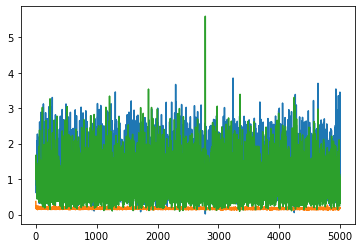

In [22]:
history = []
for i in range(0, len(Generator_loss_log)):
    history.append(i+1)

plt.figure()
plt.plot(history, Generator_loss_log)
plt.plot(history, L1_loss_log)
plt.plot(history, Discriminator_loss_log)
plt.show()

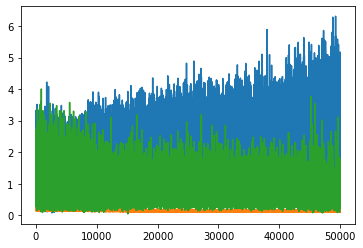

200epoch 부근부터 grnerator loss가 증가하는 것을 확인했다.

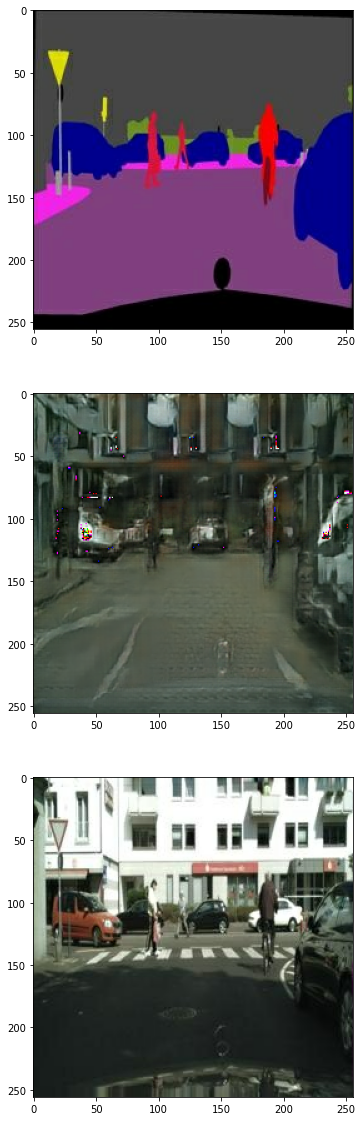

In [25]:
test_ind = 3

test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

t = test_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(t)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(60,20))
plt.subplot(3,1,1); plt.imshow(denormalize(sketch))
plt.subplot(3,1,2); plt.imshow(pred[0])
plt.subplot(3,1,3); plt.imshow(denormalize(colored))

색상의 경우 어느정도 도심의 색상에 가깝도록 맞췄지만 도로 구분을 제외한 사물의 형태에서 온전히 생성해내진 못했다.
특이사항으로 도로의 재질과 촬영 차량의 본네트의 패턴을 일치시킨 것이 확인되었다.

2000 epoch 결과
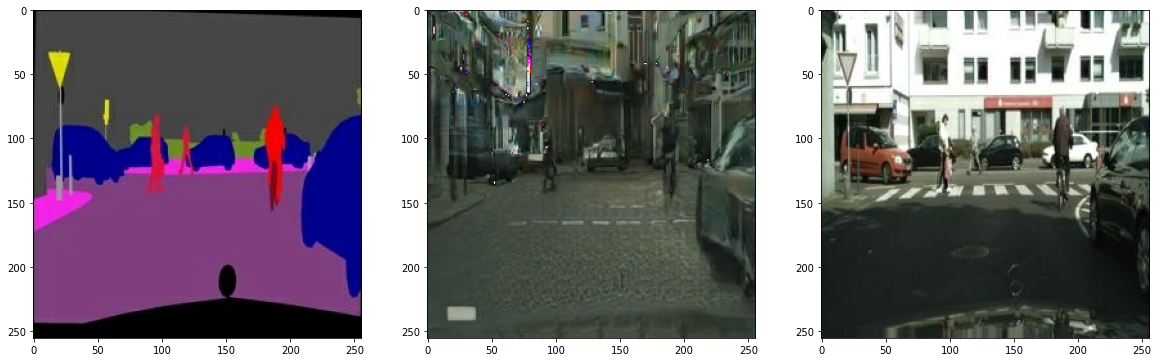

2000 epoch의 경우 loss의 발산이 관측되었으나 사람과 차의 형상이 어느정도 구분되어 생성하는 것을 확인할 수 있었으며 횡단보도 역시 완전하진 않지만 표시되어있다. 다만 건물의 경우 학습 데이터 내에 공통점이 부족하여 제대로 표현되지 못한 것을 볼 수 있다.